In [1]:
 #this code snippet was used to import our custom dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import all necessary modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# set the variables to work with throughout model
img_height = 256
img_width= 256
rgb = 3
batch_size = 10  
epochs = 50

In [4]:
# set-up training data from the original dataset only
ods_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/original_data_set', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    subset = 'training',
)

Found 3000 files belonging to 10 classes.
Using 2100 files for training.


In [5]:
# set-up training data using original plus the augmented data as well
plusAugmented_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/plusAugmented', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    subset = 'training',
)

Found 32898 files belonging to 10 classes.
Using 23029 files for training.


In [6]:
# now create a batch to test with from original dataset
ods_test = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/original_data_set', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 456,
    validation_split = 0.3,
    subset = "validation",
)

Found 3000 files belonging to 10 classes.
Using 900 files for validation.


In [7]:
# also need a batch to test with from the original plus augmented dataset
plusAugmented_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/plusAugmented', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 456,
    validation_split = 0.3,
    subset = "validation",
)

Found 32898 files belonging to 10 classes.
Using 9869 files for validation.


In [8]:
# the real test....
# NOW, a batch of unseen originals the plusAugmented model has not seen
unseen_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/unseen_originals', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 456,
)

Found 102 files belonging to 10 classes.


In [9]:
#  build up model
model = keras.models.Sequential()
model.add(keras.layers.Convolution2D(16, kernel_size = (5, 5), input_shape=(img_height, img_width, rgb ), activation='relu'))
model.add(keras.layers.Convolution2D(16, kernel_size = (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.2))
# have to make sure we pass the correct shape to LSTM
# use reshape to convert from 2D to 3D!
model.add(keras.layers.Reshape((125, -1)))
# using TimeDistributed layer
# this makes sure the dense layer keeps track of the 
# temporal aspects of the data
model.add(keras.layers.TimeDistributed(layers.Dense(50)))
model.add(keras.layers.LSTM(50, return_sequences=False))
model.add(keras.layers.Dense(10,activation = 'softmax'))

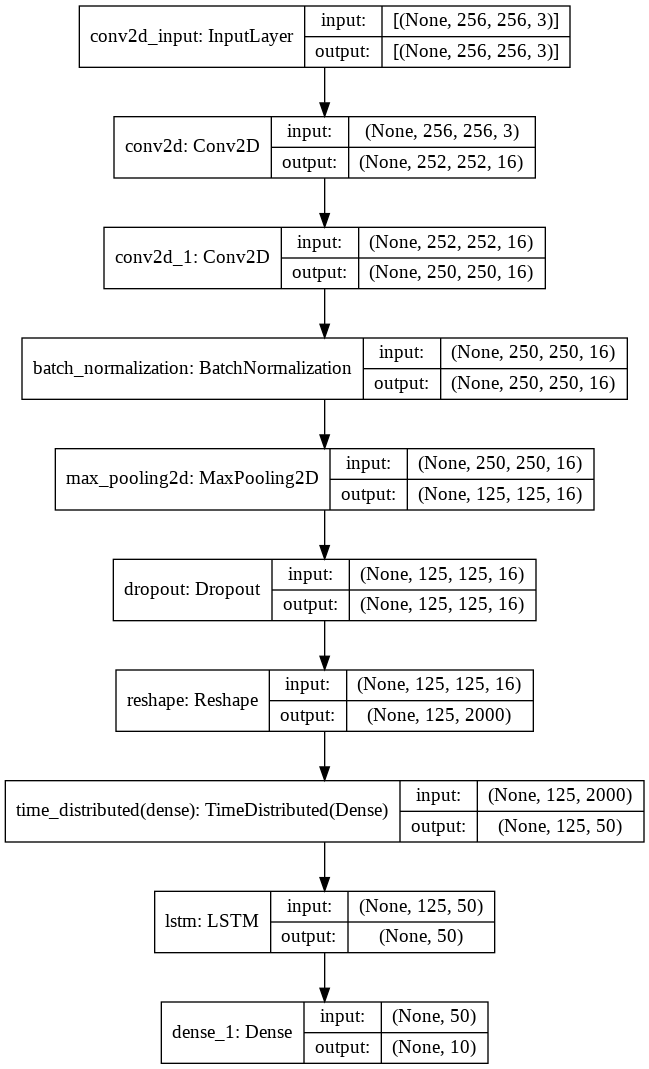

In [10]:
# display model layers w/ input and output from layers
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [11]:
# compile model   
model.compile(optimizer = keras.optimizers.Adam(),
             loss = [ keras.losses.CategoricalCrossentropy(from_logits=True)],
             metrics = [ keras.metrics.CategoricalAccuracy()])

In [12]:
# show a summary of layers and the parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
reshape (Reshape)            (None, 125, 2000)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 125, 50)           1

In [13]:
# training the original dataset
ods_history = model.fit(ods_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/50
210/210 [==============================] - 15s 55ms/step - loss: 2.2822 - categorical_accuracy: 0.1670
Epoch 2/50
210/210 [==============================] - 12s 55ms/step - loss: 1.9101 - categorical_accuracy: 0.3063
Epoch 3/50
210/210 [==============================] - 12s 55ms/step - loss: 1.7464 - categorical_accuracy: 0.3950
Epoch 4/50
210/210 [==============================] - 12s 56ms/step - loss: 1.5679 - categorical_accuracy: 0.4361
Epoch 5/50
210/210 [==============================] - 12s 55ms/step - loss: 1.4808 - categorical_accuracy: 0.4863
Epoch 6/50
210/210 [==============================] - 12s 55ms/step - loss: 1.4396 - categorical_accuracy: 0.4730
Epoch 7/50
210/210 [==============================] - 12s 55ms/step - loss: 1.2931 - categorical_accuracy: 0.5820
Epoch 8/50
210/210 [==============================] - 12s 56ms/step - loss: 1.2517 - categorical_accuracy: 0.5494
Epoch 9/50
210/210 [==============================] - 12s 55ms/step - loss: 1.1962 - cat

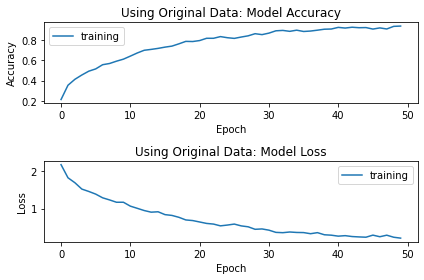

In [14]:
# how did we do?
# graphically display results of training
plt.figure()
plt.subplot(211)
plt.plot(ods_history.history['categorical_accuracy'])
plt.title('Using Original Data: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper left')

plt.subplot(212)
plt.plot(ods_history.history['loss'])
plt.title('Using Original Data: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper right')

plt.tight_layout()
plt.show()

In [15]:
# go ahead and save the model here
model.save("ods_16_f.h5")

In [16]:
# now test the model against the reserved unseen images from the original dataset
ods_t = model.evaluate(ods_test, verbose = 1)
print("Using only original test samples:")
print("Accuracy: ", ods_t[1] * 100)
print("Loss: ", ods_t[0])

90/90 [==============================] - 5s 43ms/step - loss: 0.3339 - categorical_accuracy: 0.8967
Using only original test samples:
Accuracy:  89.66666460037231
Loss:  0.3339460790157318


In [17]:
# next, we need to train with the original plus the augmented data on the exact same architecture
plusAugmented_history = model.fit(plusAugmented_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/50
2303/2303 [==============================] - 135s 59ms/step - loss: 1.0477 - categorical_accuracy: 0.6600
Epoch 2/50
2303/2303 [==============================] - 133s 58ms/step - loss: 0.7465 - categorical_accuracy: 0.7557
Epoch 3/50
2303/2303 [==============================] - 133s 58ms/step - loss: 0.6279 - categorical_accuracy: 0.7984
Epoch 4/50
2303/2303 [==============================] - 135s 58ms/step - loss: 0.5611 - categorical_accuracy: 0.8224
Epoch 5/50
2303/2303 [==============================] - 137s 59ms/step - loss: 0.5211 - categorical_accuracy: 0.8287
Epoch 6/50
2303/2303 [==============================] - 137s 59ms/step - loss: 0.4373 - categorical_accuracy: 0.8579
Epoch 7/50
2303/2303 [==============================] - 138s 60ms/step - loss: 0.4067 - categorical_accuracy: 0.8694
Epoch 8/50
2303/2303 [==============================] - 137s 59ms/step - loss: 0.3826 - categorical_accuracy: 0.8784
Epoch 9/50
2303/2303 [==============================] - 137s 59m

In [18]:
# save one last time
model.save("pA_16_f.h5")

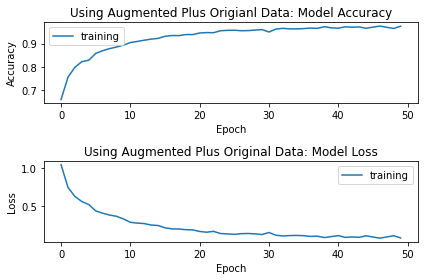

In [19]:
# how did we do?
# graphically display results of training
plt.figure()
plt.subplot(211)
plt.plot(plusAugmented_history.history['categorical_accuracy'])
plt.title('Using Augmented Plus Origianl Data: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper left')

plt.subplot(212)
plt.plot(plusAugmented_history.history['loss'])
plt.title('Using Augmented Plus Original Data: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper right')

plt.tight_layout()
plt.show()


In [20]:
# now let's test with unseen images from the augmented plus original dataset
plusAugmented_history_test = model.evaluate(plusAugmented_test, verbose = 1)
print("Using the augmented plus original test samples:")
print("Accuracy: ", plusAugmented_history_test[1] * 100)
print("Loss: ", plusAugmented_history_test[0])

987/987 [==============================] - 47s 47ms/step - loss: 0.1073 - categorical_accuracy: 0.9670
Using the augmented plus original test samples:
Accuracy:  96.69672846794128
Loss:  0.10725296288728714


In [21]:
# NOW, let's test the plusAugmented model with 100 super secret unseen original images
unseen_test_history = model.evaluate(unseen_test, verbose = 1)
print("Using completely unseen originals only:")
print("Accuracy: ", unseen_test_history[1] * 100)
print("Loss: ", unseen_test_history[0])

11/11 [==============================] - 1s 18ms/step - loss: 0.0219 - categorical_accuracy: 0.9902
Using completely unseen originals only:
Accuracy:  99.01960492134094
Loss:  0.02188560739159584
